
#Assignment Set 2

by **Amir Mehrpanah** for Deep Learing Course at Data Science Center, SBU



In [ ]:
#@title Downloading The Data
import urllib.request
import os
import ast 
import idx2numpy
import glob 

print('Downloading cifar...')

urls = ['https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
        'https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz']
for item in urls:
    urllib.request.urlretrieve(item, 'data/cifar/'+item.split('/')[-1])

!gunzip data/cifar/*.gz
!ls data/cifar/*

In [ ]:
#@title Manual Data Injection
from six.moves import cPickle as pickle
import platform
import numpy as np
 
def load_files(filenames):
    data = np.array([])
    labels = np.array([])
    for name in filenames:
        with open(name, 'rb') as f:
            mydict = pickle.load(f, encoding='latin1')

        # The labels have different names in the two datasets.
        label_func = lambda x: np.array(x['fine_labels'], dtype='int32')
        newlabels = label_func(mydict)
        if data.size:
            data = np.vstack([data, mydict['data']])
            labels = np.hstack([labels, newlabels])
        else:
            data = mydict['data']
            labels = newlabels
    data = np.reshape(data, [-1, 3, 32, 32], order='C')
    data = np.transpose(data, [0, 2, 3, 1])

    return data, labels

def load_CIFAR100(data_dir):
    """ load all of cifar """
    train_files = ['train']
    train_files = [os.path.join(data_dir, f) for f in train_files]
    test_files = ['test']
    test_files = [os.path.join(data_dir, f) for f in test_files]
    num_classes = 100
    train_data, train_labels = load_files(train_files)
    test_data, test_labels = load_files(test_files)

    return train_data, train_labels, test_data, test_labels
 
def get_CIFAR100_data(val_size=2000):
    # Load the raw CIFAR-100 data
    cifar100_dir = 'data/cifar/cifar-100-python/'
    x_train, y_train, x_test, y_test = load_CIFAR100(cifar100_dir)
    # Subsample the data
 
    x_train, x_val = np.split(x_train,
                              [x_train.shape[0]-val_size])
    y_train, y_val = np.split(y_train,
                              [y_train.shape[0]-val_size])
    
    x_train = x_train.astype('float32')
    x_val = x_val.astype('float32')
    x_test = x_test.astype('float32')
 
    x_train /= 255
    x_val /= 255
    x_test /= 255

    return x_train, y_train, x_val, y_val, x_test, y_test
 
# Invoke the above function to get our data.
x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR100_data()
 
print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (48000, 32, 32, 3)
Train labels shape:  (48000,)
Validation data shape:  (2000, 32, 32, 3)
Validation labels shape:  (2000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [ ]:
#@title Convolutional NN Tensorflow
#@markdown Training a convolutional neural network to compare the performance
name = 'conv_clf_1'
 
input = keras.Input(shape=(32,32,3))
x = layers.Conv2D(32,3,activation='relu')(input)
x = layers.Conv2D(32,3,activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(32,3,activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(32,3,activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Flatten()(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(100,'softmax')(x)

model = keras.Model(inputs=input, outputs=output, name=name)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
            optimizer='Adam',
            metrics=['accuracy'])
model.summary()

Model: "conv_clf_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_32 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_34 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 26, 26, 32)        9248      
_________________________________________________________________
batch_normalization_33 (Batc (None, 26, 26, 32)        1

In [ ]:
epochs =  100#@param {type:"integer"}
verbose =  2#@param {type:"number"}
model.fit(x = x_train, y = y_train,
                        batch_size=64, epochs=epochs,
                        verbose=verbose,validation_data=(x_val,y_val),
                        validation_batch_size = 32)

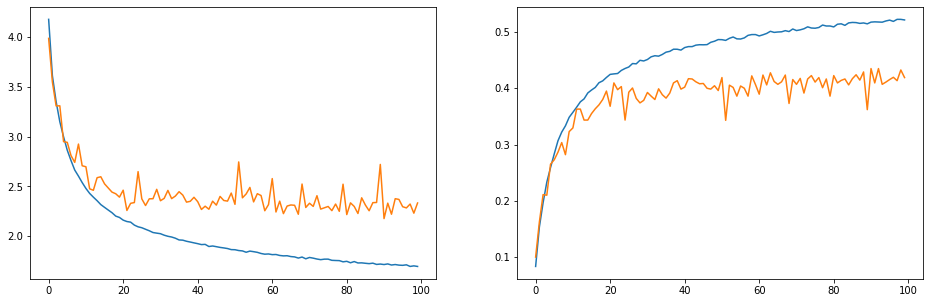

In [ ]:
#@title Twenty epochs is just enough!
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.3443 - accuracy: 0.4251


[2.344250202178955, 0.4250999987125397]

In [ ]:
#@title Convolutional NN Pytorch
#@markdown Training a convolutional neural network to compare the performance

model = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=(3,3)),
        nn.ReLU(),
        nn.Conv2d(32,32,kernel_size=(3,3)),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout2d(p=0.5),
        nn.Conv2d(32,32,kernel_size=(3,3)),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Dropout2d(p=0.5),
        nn.Conv2d(32,32,kernel_size=(3,3)),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout2d(p=0.4),
        nn.Flatten(),
        nn.Linear(3872,128),
        nn.ReLU(),
        nn.Dropout2d(p=0.2),
        nn.Linear(128,100),
        nn.Softmax(0)
    )
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#@title Training The Network
epochs = 200 #@param {type:"integer"}
train_losses = []
validation_losses = []
len_train_data = len(trainloader.sampler) 
len_validation_data = len(testloader.sampler)
training_steps = len_train_data/trainloader.batch_size
validation_steps = len_validation_data/testloader.batch_size

for epoch in range(epochs):  
    train_loss=0.0
    validation_loss=0.0
   
    model.train()
    print('training steps')
    for i,(inputs, labels) in enumerate(trainloader):
        print('\rtraining step {} of {}'.format(i,training_steps),end='')
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss +=loss.item()*inputs.size(0)
    print('\nvalidation steps')
    model.eval()
    for i,(inputs, labels) in enumerate(testloader):
        print('\rvalidation step {} of {}'.format(i,validation_steps),end='')
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        validation_loss +=loss.item()*inputs.size(0)
    
    train_loss=train_loss/len_train_data
    validation_loss=validation_loss/len_validation_data

    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    print('\nEpoch:{} Train Loss:{:.4f} validation Loss:{:.4f}'.format(epoch,train_loss,validation_loss))  

print('Finished Training')

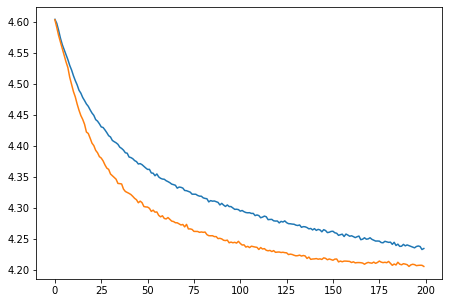

In [ ]:
#@title Training Loss
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(train_losses)
plt.plot(validation_losses)